**Dataset & dataloaders**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw






  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw






  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw






  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




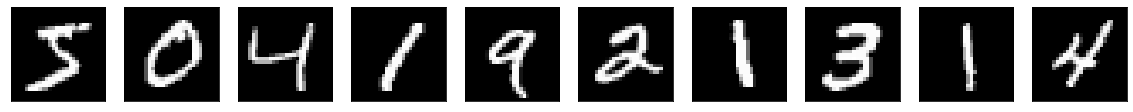

In [1]:
# Import the required libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Import the required libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])
batch_size = 256 # batch size

# Download and load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a data loader to load the dataset in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

num_pictures = 10  # Plot the first 10 images from the dataset
plt.figure(figsize=(20,5))  # Create a new figure. The figsize parameter is used to set the size of the figure in inches, in this case (20,5). 
for i in range(num_pictures):
	img = trainset[i][0]
	ax = plt.subplot(1,num_pictures,i+1)
	# Make x-axis and y-axis not visible
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)  
	# Plot the image
plt.show()

**Model architecture**

In [2]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

layers = 8 		# Number of layers in the network
kernel = 7 		# Kernel size
channels = 64 # Depth of the intermediate layers

# This is a custom class that is inheriting from the PyTorch class "nn.Conv2d". The "nn.Conv2d" class is a 2D convolutional layer,
# and the "MaskedCNN" class adds functionality for masking certain weights to the standard convolutional layer.
class MaskedCNN(nn.Conv2d):
	"""
	Taken from https://github.com/jzbontar/pixelcnn-pytorch
	"""
	def __init__(self, mask_type, *args, **kwargs):
		self.mask_type = mask_type
		assert mask_type in ['A', 'B'], "Unknown Mask Type"
		# Mask
		#         -------------------------------------
		#        |  1       1       1       1       1 |
		#        |  1       1       1       1       1 |
		#        |  1       1    1 if B     0       0 |   H // 2
		#        |  0       0       0       0       0 |   H // 2 + 1
		#        |  0       0       0       0       0 |
		#         -------------------------------------
		#  index    0       1     W//2    W//2+1

		super(MaskedCNN, self).__init__(*args, **kwargs)
		self.register_buffer('mask', self.weight.data.clone())
		_, depth, height, width = self.weight.size()
		self.mask.fill_(1)  # the tensor is being filled with the value of 1
		if mask_type =='A':
			self.mask[:,:,height//2,width//2:] = 0
			self.mask[:,:,height//2+1:,:] = 0
		else:
			self.mask[:,:,height//2,width//2+1:] = 0
			self.mask[:,:,height//2+1:,:] = 0


	def forward(self, x):
		self.weight.data*=self.mask # Applying the mask to the weights before forwarding
		return super(MaskedCNN, self).forward(x)

# The PixelCNN is used to create the neural network. It is defined as a subclass of the nn.Module class from the PyTorch library.
class PixelCNN(nn.Module):
	def __init__(self, no_layers=8, kernel = 7, channels=64, device=None):
		super(PixelCNN, self).__init__()
		self.no_layers = no_layers
		self.kernel = kernel
		self.channels = channels
		self.layers = {}
		self.device = device

		self.MaskAConv = nn.Sequential( # Creating a sequential module called "MaskAConv"
			MaskedCNN('A',1,channels, kernel, 1, kernel//2, bias=False), 	# Initializing a MaskedCNN module with "A" mask, 1 input channel, 
																																		# specified number of output channels, kernel size, stride of 1 and padding
																																		# of kernel//2, bias=False to not include bias term
			nn.BatchNorm2d(channels), 	# Applying batch normalization
			nn.ReLU(True) 							# Applying ReLU activation
		)

		MaskBConv = []
		for i in range(8):
			MaskBConv.append(MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False))
			MaskBConv.append(nn.BatchNorm2d(channels))
			MaskBConv.append(nn.ReLU(True))

		self.MaskBConv = nn.Sequential(*MaskBConv)

		self.out = nn.Conv2d(channels, 256, 1)	#"channels"  represents the number of input channels for the convolutional layer.
																						#"256"  represents the number of output channels for the convolutional layer.
																						# "1"  represents the kernel size of the convolutional layer.

	def forward(self, x):
		x = self.MaskAConv(x)
		x = self.MaskBConv(x)
		return self.out(x)

model = PixelCNN().to(device)	# Create an instance of the PixelCNN model, and assign it to the variable 'model'.
                          		# The 'to(device)' function is used to move the model to a specified device like GPU if available,
                          		# it is used to perform computations on the model using the specified device.

print(model)     # Show the model architecture

PixelCNN(

  (MaskAConv): Sequential(

    (0): MaskedCNN(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU(inplace=True)

  )

  (MaskBConv): Sequential(

    (0): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU(inplace=True)

    (3): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (5): ReLU(inplace=True)

    (6): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (8): ReLU(inplace=True)

    (9): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

**Optimizer and loss function**

In [ ]:
# Import the torch.optim module, which contains various optimization algorithms, and assigns it to the variable "optim".
# This allows the user to call various optimization functions such as Adam, SGD, etc from the optim module using the "optim" variable.
import torch.optim as optim

#Initialize the optimizer with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Define the loss function as Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

**Sampling**

In [ ]:
# Import the math module. The module contains various mathematical functions and constants
# such as trigonometric functions, logarithmic functions, and the constant pi. 
import math

no_images = 5 # Number of images to generate
images_size = 28 # Size of each image
images_channels = 1 # Number of channels in the image

#Function for generating and displaying the images
def sampling():
	model.eval() # Set the model to evaluation mode
	sample = torch.Tensor(no_images, images_channels, images_size, images_size).to(device) #Create a tensor to store the generated images
	sample.fill_(0) # Fill the tensor with 0s

  #Generating images pixel by pixel
	for i in range(images_size):
		for j in range(images_size):
			out = model(sample)
			probs = F.softmax(out[:,:,i,j], dim=-1).data	# Get the probability distribution of the output. 
																										# F.softmax function to calculate the probabilities for the output at a specific location (i,j)
																										# The dim=-1 argument specifies that the softmax should be applied to the last dimension of the tensor.
																										# The .data attribute is used to extract the underlying data of the tensor and convert it to a numpy ndarray.
			sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0 # This line of code is using the torch.multinomial function from the PyTorch library to sample from
																																		# a probability distribution represented by the input tensor probs.
																																		# The function takes the input tensor, and samples a single value from it according to
																																		# the probabilities of each element in the tensor. The argument 1 passed to
																																		# torch.multinomial indicates that we want to sample one value. The output of this function
																																		# is a tensor of size 1 that contains the index of the sampled value.
																																		# The result is then divided by 255.0 to normalize the values to be between 0 and 1.


	plt.figure(figsize=(10,10))  # Create a figure with specified size
	for i in range(no_images):
		ax = plt.subplot(1,no_images,i+1)
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)  
		plt.imshow(transforms.ToPILImage()(sample[i,:,:,:]), interpolation="bicubic",cmap='gist_gray') #This line of code is using the plt.imshow function from
																	# matplotlib library to display an image. It is displaying the i-th image from the sample tensor which is 4-dimensional tensor.
																	# The transforms.ToPILImage() function is used to convert the tensor to a PIL (Python Imaging Library) image object,
																	# which can be displayed using matplotlib's imshow function.
																	# The interpolation="bicubic" argument is used to specify the interpolation method for resampling the image.
																	# The cmap='gist_gray' argument is used to set the colormap of the image to grayscale.

	plt.show()

**Training**

Training Started


epoch: 1 of 100, loss: 1.898: : 235it [01:32,  2.53it/s]


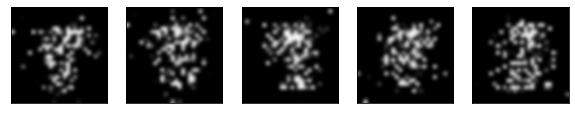

epoch: 2 of 100, loss: 0.990: : 235it [01:23,  2.81it/s]


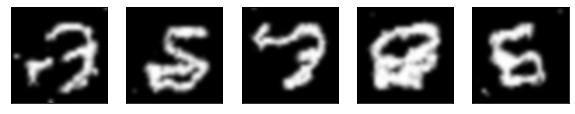

epoch: 3 of 100, loss: 0.811: : 235it [01:23,  2.80it/s]


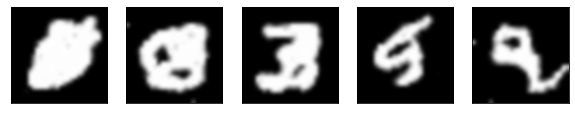

epoch: 4 of 100, loss: 0.786: : 235it [01:23,  2.80it/s]


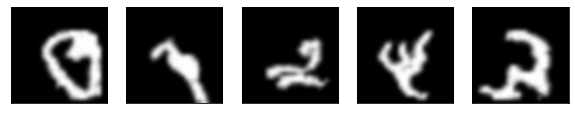

epoch: 5 of 100, loss: 0.771: : 235it [01:24,  2.79it/s]


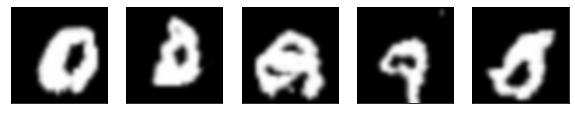

epoch: 6 of 100, loss: 0.760: : 235it [01:23,  2.80it/s]


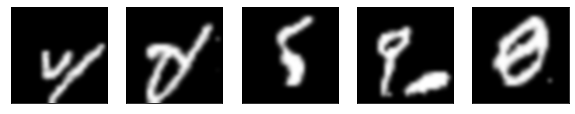

epoch: 7 of 100, loss: 0.752: : 235it [01:23,  2.80it/s]


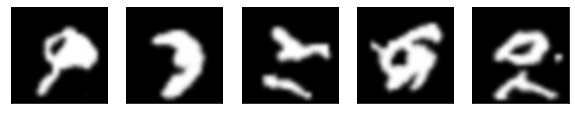

epoch: 8 of 100, loss: 0.746: : 235it [01:23,  2.80it/s]


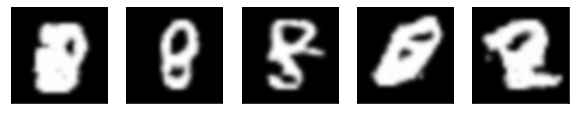

epoch: 9 of 100, loss: 0.742: : 235it [01:24,  2.79it/s]


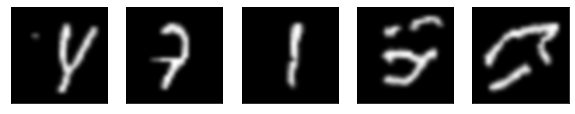

epoch: 10 of 100, loss: 0.738: : 235it [01:24,  2.80it/s]


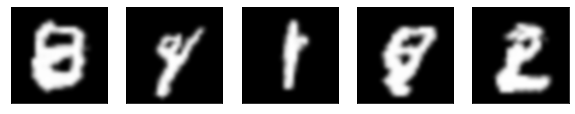

epoch: 11 of 100, loss: 0.734: : 235it [01:24,  2.79it/s]


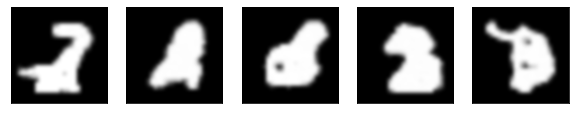

epoch: 12 of 100, loss: 0.730: : 235it [01:24,  2.79it/s]


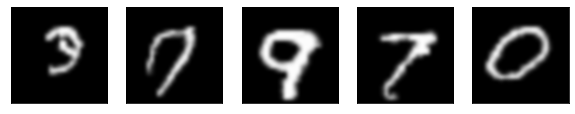

epoch: 13 of 100, loss: 0.727: : 235it [01:24,  2.78it/s]


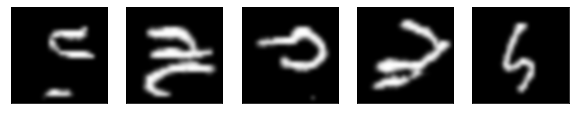

epoch: 14 of 100, loss: 0.723: : 235it [01:24,  2.79it/s]


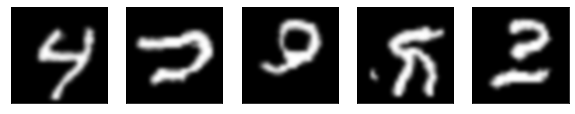

epoch: 15 of 100, loss: 0.719: : 235it [01:24,  2.78it/s]


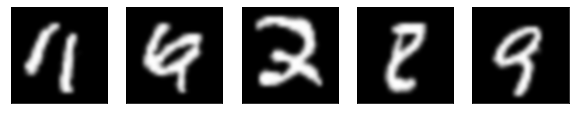

epoch: 16 of 100, loss: 0.715: : 235it [01:24,  2.78it/s]


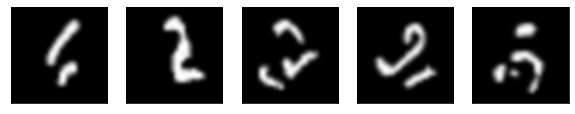

epoch: 17 of 100, loss: 0.712: : 235it [01:24,  2.78it/s]


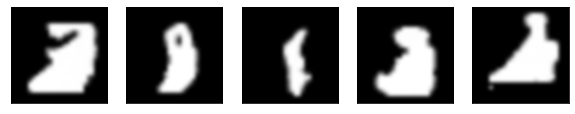

epoch: 18 of 100, loss: 0.707: : 235it [01:24,  2.79it/s]


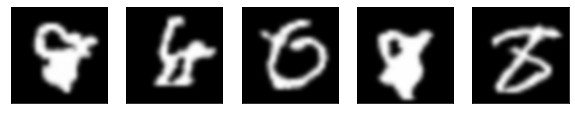

epoch: 19 of 100, loss: 0.703: : 235it [01:24,  2.78it/s]


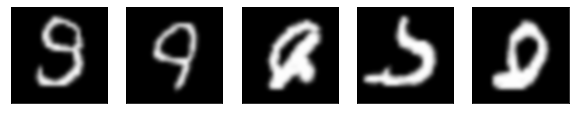

epoch: 20 of 100, loss: 0.698: : 235it [01:24,  2.78it/s]


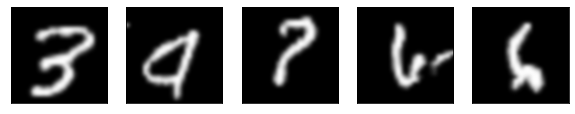

epoch: 21 of 100, loss: 0.694: : 235it [01:24,  2.77it/s]


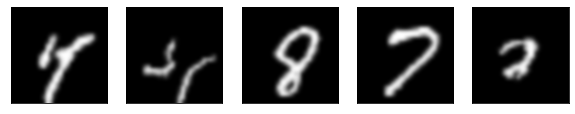

epoch: 22 of 100, loss: 0.689: : 235it [01:24,  2.78it/s]


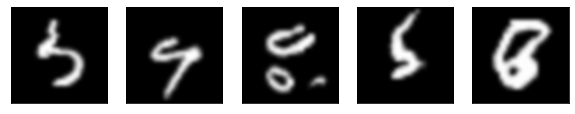

epoch: 23 of 100, loss: 0.684: : 235it [01:24,  2.78it/s]


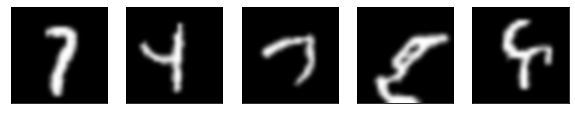

epoch: 24 of 100, loss: 0.679: : 235it [01:24,  2.78it/s]


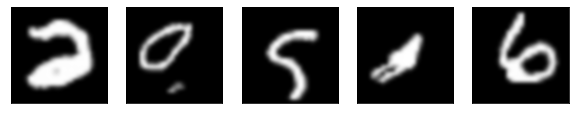

epoch: 25 of 100, loss: 0.674: : 235it [01:24,  2.78it/s]


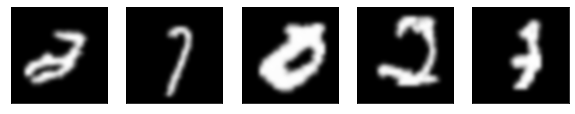

epoch: 26 of 100, loss: 0.670: : 235it [01:24,  2.78it/s]


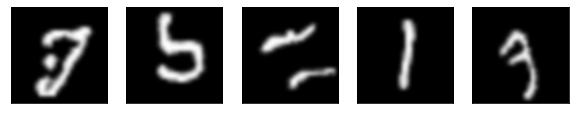

epoch: 27 of 100, loss: 0.666: : 235it [01:24,  2.78it/s]


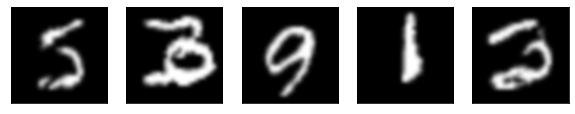

epoch: 28 of 100, loss: 0.663: : 235it [01:24,  2.77it/s]


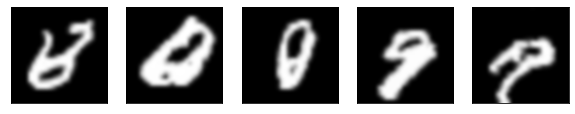

epoch: 29 of 100, loss: 0.657: : 235it [01:24,  2.77it/s]


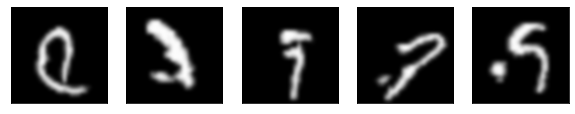

epoch: 30 of 100, loss: 0.656: : 235it [01:24,  2.77it/s]


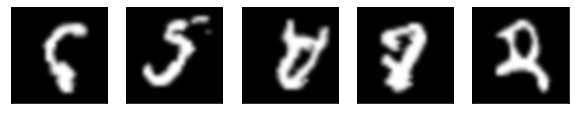

epoch: 31 of 100, loss: 0.651: : 235it [01:24,  2.77it/s]


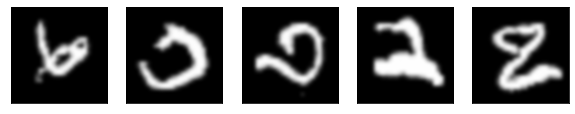

epoch: 32 of 100, loss: 0.646: : 235it [01:24,  2.77it/s]


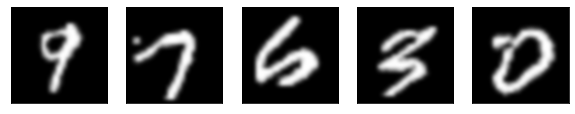

epoch: 33 of 100, loss: 0.643: : 235it [01:24,  2.77it/s]


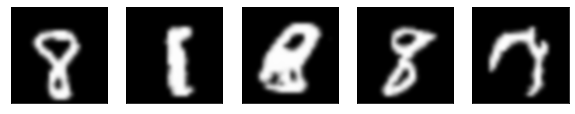

epoch: 34 of 100, loss: 0.639: : 235it [01:24,  2.77it/s]


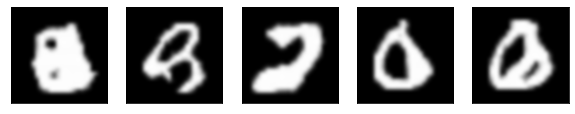

epoch: 35 of 100, loss: 0.637: : 235it [01:24,  2.77it/s]


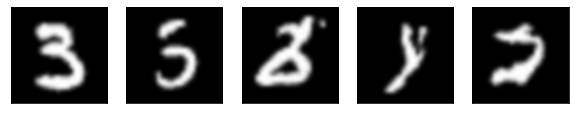

epoch: 36 of 100, loss: 0.635: : 235it [01:25,  2.76it/s]


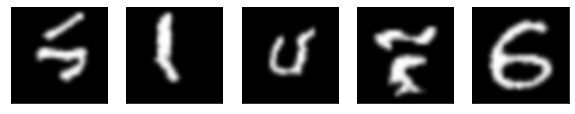

epoch: 37 of 100, loss: 0.631: : 235it [01:24,  2.77it/s]


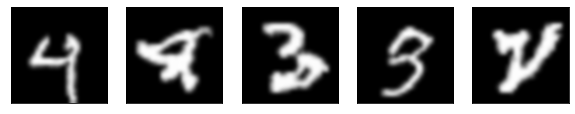

epoch: 38 of 100, loss: 0.628: : 235it [01:25,  2.75it/s]


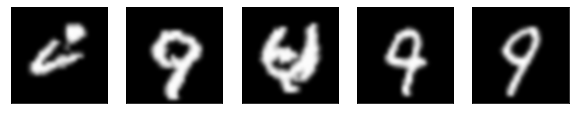

epoch: 39 of 100, loss: 0.626: : 235it [01:24,  2.77it/s]


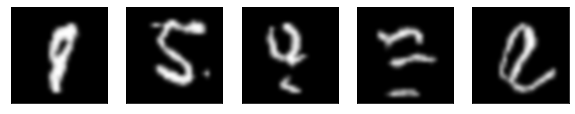

epoch: 40 of 100, loss: 0.625: : 235it [01:25,  2.76it/s]


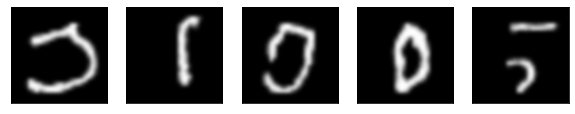

epoch: 41 of 100, loss: 0.625: : 235it [01:25,  2.76it/s]


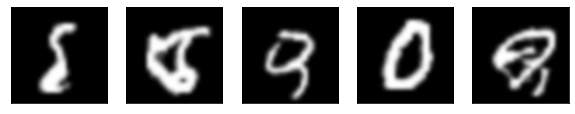

epoch: 42 of 100, loss: 0.622: : 235it [01:25,  2.76it/s]


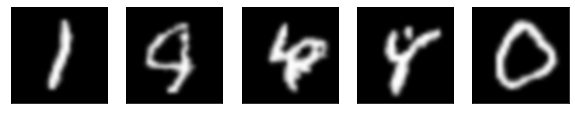

epoch: 43 of 100, loss: 0.620: : 235it [01:25,  2.76it/s]


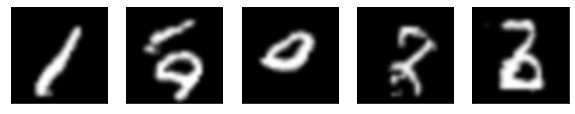

epoch: 44 of 100, loss: 0.622: : 235it [01:25,  2.75it/s]


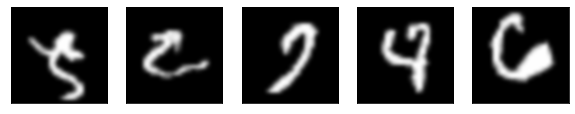

epoch: 45 of 100, loss: 0.615: : 235it [01:25,  2.75it/s]


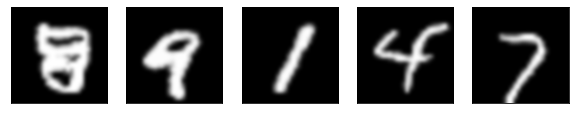

epoch: 46 of 100, loss: 0.614: : 235it [01:25,  2.75it/s]


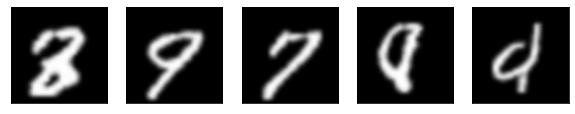

epoch: 47 of 100, loss: 0.612: : 235it [01:25,  2.74it/s]


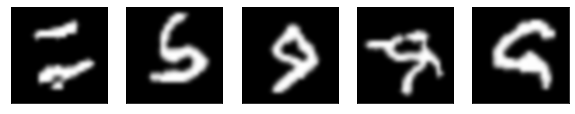

epoch: 48 of 100, loss: 0.610: : 235it [01:25,  2.75it/s]


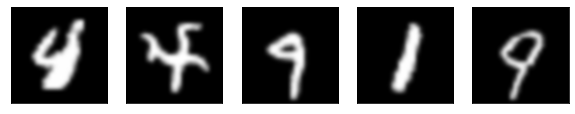

epoch: 49 of 100, loss: 0.611: : 235it [01:25,  2.75it/s]


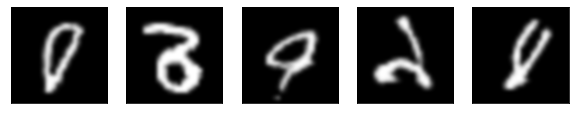

epoch: 50 of 100, loss: 0.608: : 235it [01:25,  2.75it/s]


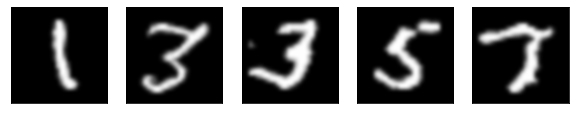

epoch: 51 of 100, loss: 0.606: : 235it [01:25,  2.74it/s]


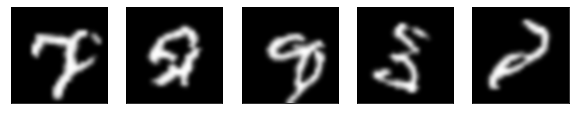

epoch: 52 of 100, loss: 0.606: : 235it [01:25,  2.75it/s]


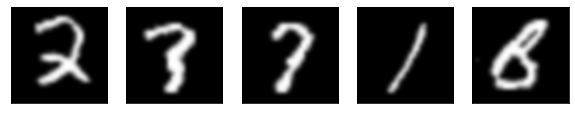

epoch: 53 of 100, loss: 0.604: : 235it [01:25,  2.75it/s]


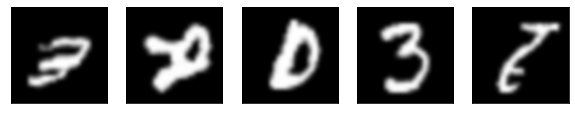

epoch: 54 of 100, loss: 0.603: : 235it [01:25,  2.75it/s]


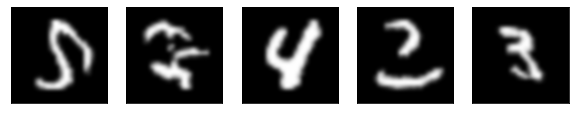

epoch: 55 of 100, loss: 0.605: : 235it [01:25,  2.75it/s]


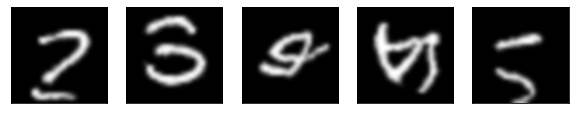

epoch: 56 of 100, loss: 0.600: : 235it [01:25,  2.74it/s]


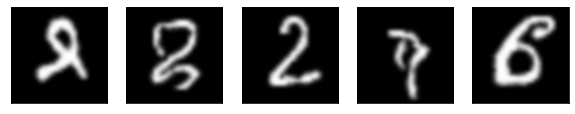

epoch: 57 of 100, loss: 0.601: : 235it [01:25,  2.75it/s]


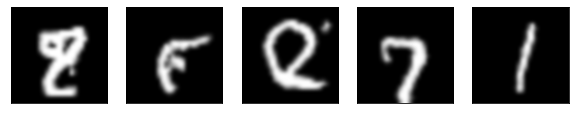

epoch: 58 of 100, loss: 0.598: : 235it [01:25,  2.75it/s]


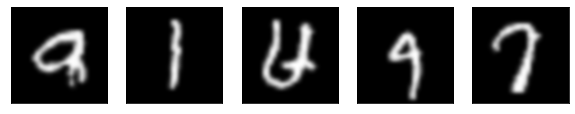

epoch: 59 of 100, loss: 0.599: : 235it [01:25,  2.74it/s]


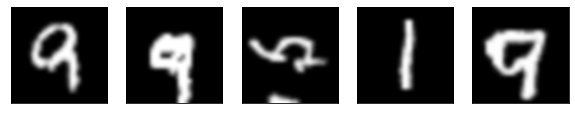

epoch: 60 of 100, loss: 0.597: : 235it [01:25,  2.75it/s]


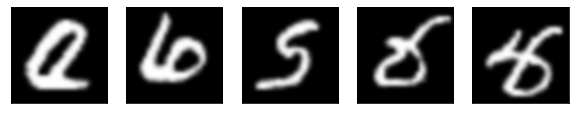

epoch: 61 of 100, loss: 0.595: : 235it [01:25,  2.75it/s]


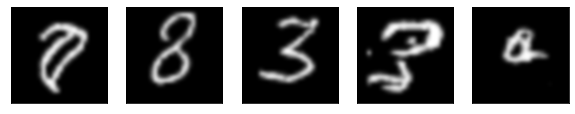

epoch: 62 of 100, loss: 0.599: : 235it [01:25,  2.75it/s]


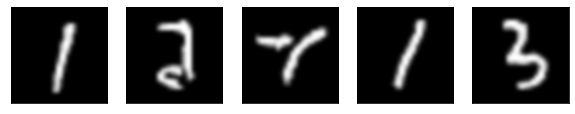

epoch: 63 of 100, loss: 0.598: : 235it [01:25,  2.74it/s]


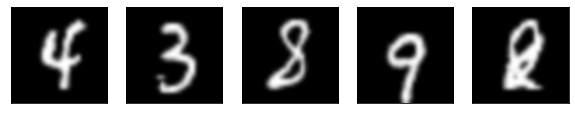

epoch: 64 of 100, loss: 0.592: : 235it [01:25,  2.75it/s]


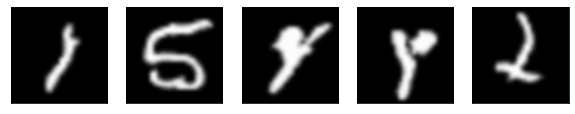

epoch: 65 of 100, loss: 0.594: : 235it [01:25,  2.74it/s]


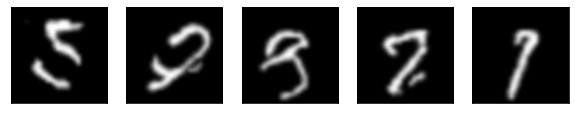

epoch: 66 of 100, loss: 0.591: : 235it [01:25,  2.75it/s]


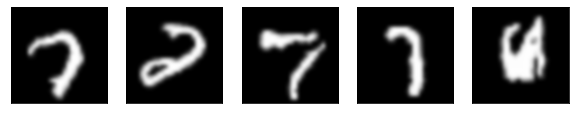

epoch: 67 of 100, loss: 0.591: : 235it [01:25,  2.74it/s]


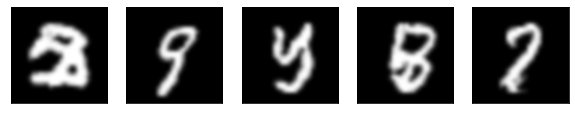

epoch: 68 of 100, loss: 0.590: : 235it [01:25,  2.74it/s]


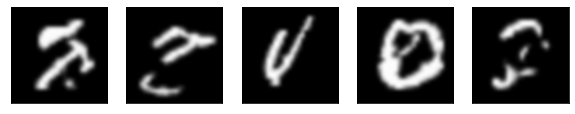

epoch: 69 of 100, loss: 0.597: : 235it [01:25,  2.75it/s]


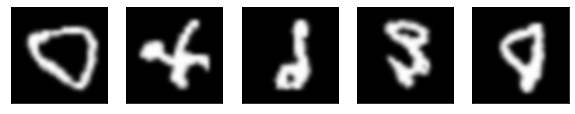

epoch: 70 of 100, loss: 0.593: : 235it [01:25,  2.75it/s]


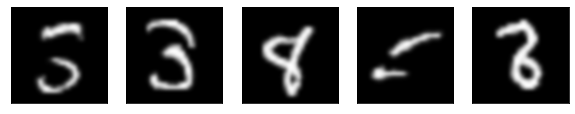

epoch: 71 of 100, loss: 0.586: : 235it [01:25,  2.74it/s]


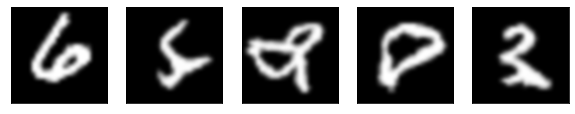

epoch: 72 of 100, loss: 0.588: : 235it [01:25,  2.75it/s]


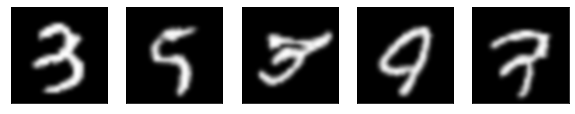

epoch: 73 of 100, loss: 0.588: : 235it [01:25,  2.74it/s]


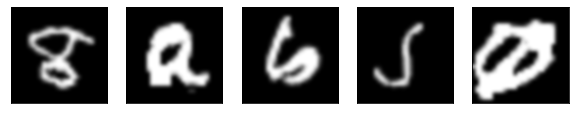

epoch: 74 of 100, loss: 0.589: : 235it [01:25,  2.75it/s]


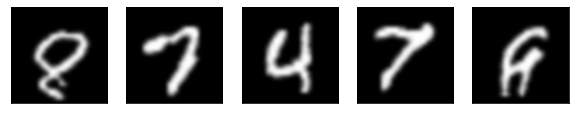

epoch: 75 of 100, loss: 0.586: : 235it [01:25,  2.75it/s]


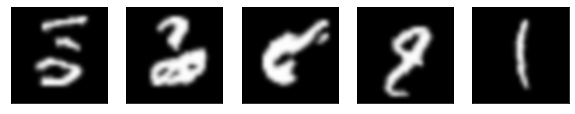

epoch: 76 of 100, loss: 0.586: : 235it [01:25,  2.75it/s]


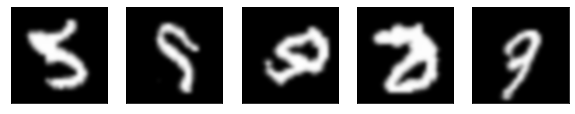

epoch: 77 of 100, loss: 0.586: : 235it [01:25,  2.75it/s]


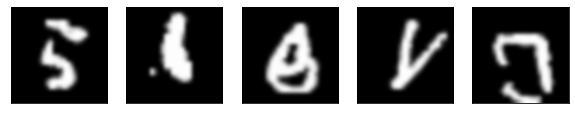

epoch: 78 of 100, loss: 0.584: : 235it [01:25,  2.75it/s]


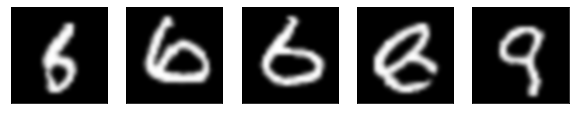

epoch: 79 of 100, loss: 0.585: : 235it [01:25,  2.74it/s]


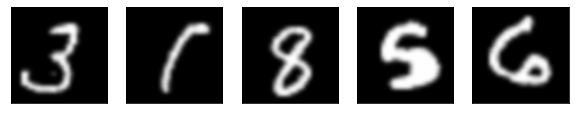

epoch: 80 of 100, loss: 0.585: : 235it [01:25,  2.75it/s]


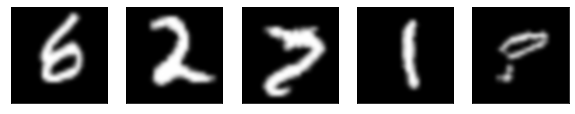

epoch: 81 of 100, loss: 0.588: : 235it [01:25,  2.74it/s]


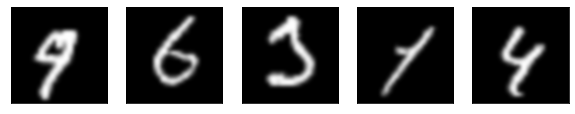

epoch: 82 of 100, loss: 0.583: : 235it [01:25,  2.75it/s]


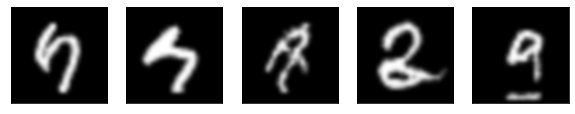

epoch: 83 of 100, loss: 0.582: : 235it [01:25,  2.75it/s]


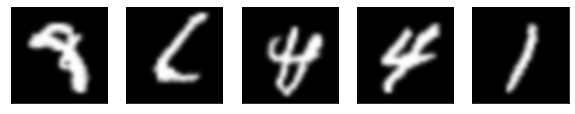

epoch: 84 of 100, loss: 0.581: : 235it [01:25,  2.75it/s]


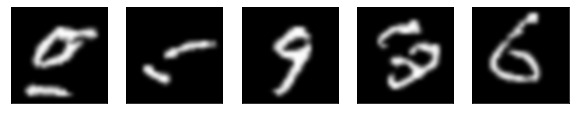

epoch: 85 of 100, loss: 0.588: : 235it [01:25,  2.75it/s]


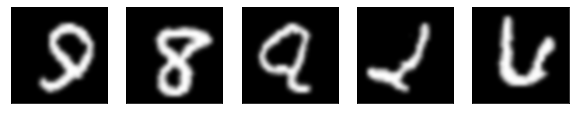

epoch: 86 of 100, loss: 0.579: : 235it [01:25,  2.75it/s]


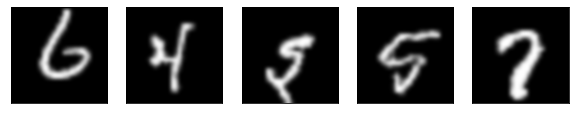

epoch: 87 of 100, loss: 0.582: : 235it [01:25,  2.74it/s]


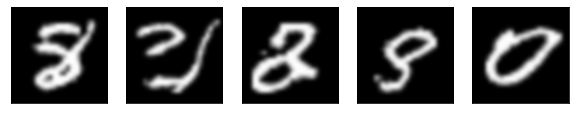

epoch: 88 of 100, loss: 0.597: : 235it [01:25,  2.75it/s]


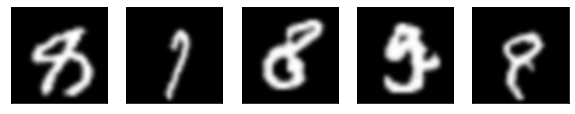

epoch: 89 of 100, loss: 0.582: : 235it [01:25,  2.74it/s]


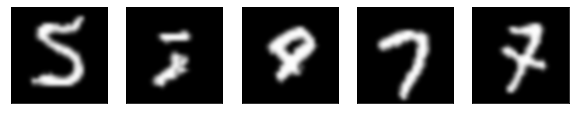

epoch: 90 of 100, loss: 0.581: : 235it [01:25,  2.75it/s]


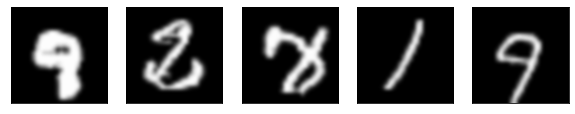

epoch: 91 of 100, loss: 0.578: : 235it [01:25,  2.74it/s]


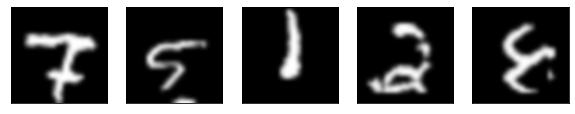

epoch: 92 of 100, loss: 0.577: : 235it [01:25,  2.75it/s]


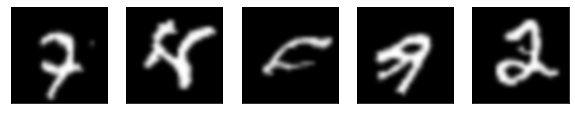

epoch: 93 of 100, loss: 0.580: : 235it [01:25,  2.75it/s]


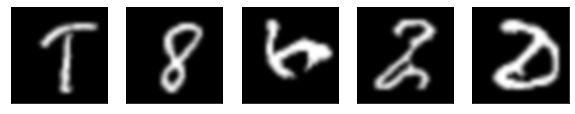

epoch: 94 of 100, loss: 0.580: : 235it [01:25,  2.74it/s]


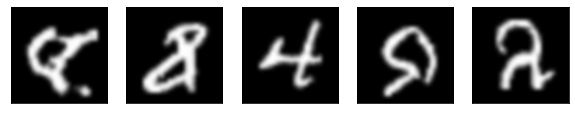

epoch: 95 of 100, loss: 0.578: : 235it [01:25,  2.75it/s]


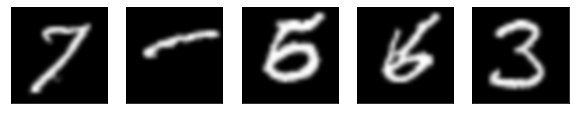

epoch: 96 of 100, loss: 0.577: : 235it [01:25,  2.75it/s]


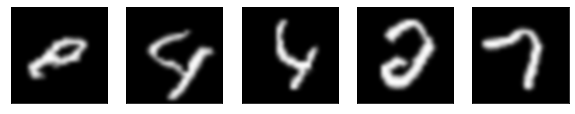

epoch: 97 of 100, loss: 0.580: : 235it [01:25,  2.74it/s]


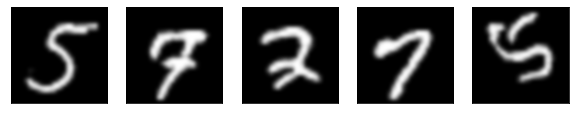

epoch: 98 of 100, loss: 0.578: : 235it [01:25,  2.75it/s]


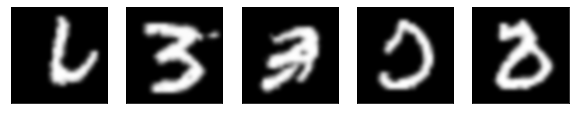

epoch: 99 of 100, loss: 0.584: : 235it [01:25,  2.74it/s]


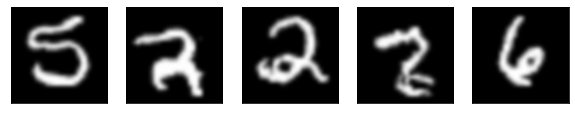

epoch: 100 of 100, loss: 0.575: : 235it [01:25,  2.75it/s]


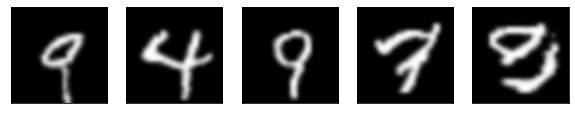

Training Finished


In [ ]:
# Import tqdm library
from tqdm import tqdm #tqdm is a library for creating progress bars in the command line interface (CLI) for Python. 

#number of epochs for training
num_epochs = 100

print("Training Started")	# Start the training
for epoch in range(num_epochs):  # Loop over the dataset multiple times
		model.train()		# The model is set to training mode, which enables any operations that are specific to the training mode.
		running_loss = 0.0
		pbar = tqdm(enumerate(trainloader, 0), total=int(len(trainset) / trainloader.batch_size))
		for i, data in pbar:
				# Get the inputs; data is a list of [inputs, labels]
				inputs, _ = data

				target = (inputs[:, 0, :, :] * 255).long()  # The input tensor is a 4-dimensional tensor with the shape (batch_size, channels, height, width).
																										# It means it's selecting all the images of the first channel from the input tensor,
																										# multiplying them by 255, and casting them to a long datatype.
																										
				inputs = inputs.to(device)	# Move the inputs tensor from its current location to a specific device
				target = target.to(device)	# Move the inputs tensor from its current location to a specific device

				# Zero the parameter gradients
				optimizer.zero_grad()	# Before the optimizer updates the parameters, the gradients need to be zeroed out so that the optimizer can calculate
															# the new gradients for the current iteration. This is because the gradients are accumulated across iterations,
															# which can cause the optimizer to update the parameters in a direction that is not correct.

				# Forward + backward + optimize
				outputs = model(inputs)	# Calculation of the model's output
				loss = criterion(outputs, target)	# calculation of the loss between the model's output and the target using a criterion function.
				loss.backward()		# computation of the gradients of the loss with respect to the model's parameters. This is done using the "backward" method on the loss tensor.
				optimizer.step()	# updates of the model's parameters. This step will update the model's parameters in the direction that reduces the loss.

				# Print statistics
				running_loss += loss.item()	# Accumulate the loss
				pbar.set_description(f'epoch: {epoch + 1} of {num_epochs}, loss: {running_loss/(i+1):.3f}')	# print the current epoch, the total epochs
																																																		# and the average of the losses

		# Show samples
		sampling()

print('Training Finished')	# Training finished

#Save trained model:
PATH = './savedModel.pth'
torch.save(model.state_dict(), PATH)